**Import Library**

In [1]:
import re
import pandas as pd
import plotly.express as px
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
import os
import pandas as pd
import numpy as np
import shutil
import matplotlib.pyplot as plt
import sys
import tqdm.notebook as tq
from collections import defaultdict
from transformers import AdamW
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, classification_report
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**Read the Dataset**

In [2]:
df = pd.read_csv("/kaggle/input/labelclassification/reviewsDataset.csv")
df.head()

,reviewContent,ground_truth_aspects
0,"আলহামদুলিল্লাহ, প্রোডাক্টটি অনেক ভালো! সাউন্ড ...","product, packaging"
1,"অসাধারণ একটা প্রডাক্ট হাতে পেলাম,সত্যিই অসাধার...","product, seller, packaging"
2,আসা করি যে ভালো হবে কিন্তু অনেক ভালো ছিল চালে ...,"product, seller"
3,"যেমন ওর্ডার করেছি তেমন পেয়েছি,প্যাকেটিং ভালো ছ...","product, packaging, seller"
4,১০০% আসল প্রোডাক্ট। সিলেটের মধ্যে ৮ দিনের মধ্য...,"product, delivery, seller"


In [3]:
df.reviewContent[617]

'রাইডার ভালো 👍'

In [4]:
df.sample(40)

,reviewContent,ground_truth_aspects
721,খুবই ভালো পণ্য। ঠিকমত পেয়েছি। ধন্যবাদ সেলার এ...,"product, seller"
125,"প্যাকেজিংটা দারুণ ছিল, আর বিক্রেতাও খুব ভালো। ...","packaging, seller, product"
747,"ভাল প্রোডাক্ট, বাচ্চার খুব পছন্দ",product
808,"ডেলিভারি ডেটের আগেই পেয়েছি, ধন্যবাদ",delivery
446,ভালো অবস্থায় পেয়েছি। ডেলিভারি ম্যান খুব সহযোগী।,"packaging, rider"
982,সেলারকে ধন্যবাদ কমদামে সঠিক পণ্যটি দেয়ার জন্য।...,"product, seller, price, shelf"
147,Speaker/Desk Clock টির দাম অনুযায়ী গুণগত মান ...,product
710,অসাধারণ পণ্য পেয়েছি। দারাজকে ধন্যবাদ জানাই ভা...,"product, delivery"
1004,সন্তুষ্ট। যদিও কফির সাথে প্লাস্টিকের জার দেখান...,"product, seller"
1348,আসল জিনিস। ধন্যবাদ,product


**Clean the Dataset**

In [5]:
def clean_text(text):
    # Regular expression to match only Bengali characters, digits, and special characters
    pattern = re.compile(r'[^০-৯\u0980-\u09FF\s,.!?\'"@#$%^&*()_+=\-`~<>:;"{}[\]\\|/]')
    filtered_string = pattern.sub('', text)
    output_string = re.sub(r'\s+', ' ', filtered_string).strip()
    return output_string

# Apply the function to the 'text' column
df['reviewContent'] = df['reviewContent'].apply(clean_text)

df.sample(50)

,reviewContent,ground_truth_aspects
1514,ভালো পণ্য অরিজিনাল পাওয়া যায় এবং সর্বাধিক দ্...,"product, delivery"
890,প্রোডাক্টের জন্য ধন্যবাদ,product
398,"দ্রুত ডেলিভারি পেয়েছি, প্রোডাক্ট নিয়ে কোন কথা ...","product, delivery"
1521,ধন্যবাদ দারাজকে ঠিকমত বাসায় পৌঁছে দেওয়াতে,delivery
960,পেকেজের মান খুব খারাপ কনটেইনারের মান খুব খারাপ...,"product, packaging"
281,প্রোডাক্ট প্যাকেজিং ও মেয়াদ দুটাই ঠিকঠাক মত পে...,"packaging, shelf"
695,এর আগে দোকান থেকে কিনছিলাম ছেলে খুব ভালো খেল ক...,product
1,"অসাধারণ একটা প্রডাক্ট হাতে পেলাম,সত্যিই অসাধার...","product, seller, packaging"
988,"""পণ্য সব ঠিক আছে, প্যাকেজিংও ঠিক ছিল, পণ্যের ক...","product, packaging, seller"
48,আইটেমটি ভালো এবং সাউন্ডও গ্রহণযোগ্য তাই আমি এই...,"product, seller"


In [6]:
df.shape

(1648, 2)

**Check Null Value**

In [7]:
df.isnull().sum()

reviewContent            0
ground_truth_aspects    67
dtype: int64

**Drop Null Value**

In [8]:
df = df.dropna()

In [9]:
df.shape

(1581, 2)

In [10]:
# Create a set to hold unique aspects
unique_aspects = set()

# Split the aspects and update the unique_aspects set
df['ground_truth_aspects'].str.split(', ').apply(unique_aspects.update)

# Strip spaces from unique aspects and remove any empty strings
unique_aspects = {aspect.strip() for aspect in unique_aspects if aspect.strip()}

# Create a new column for each unique aspect and initialize with 0
for aspect in unique_aspects:
    df[aspect] = 0

# Populate the columns based on the aspects present in each row
for index, row in df.iterrows():
    aspects = [aspect.strip() for aspect in row['ground_truth_aspects'].split(', ')]
    for aspect in aspects:
        if aspect:  # only update if aspect is not an empty string
            df.at[index, aspect] = 1

In [11]:
df.head()

,reviewContent,ground_truth_aspects,"product,price",product,"seller,shelf",packaging,seller,packaging product,service,shelf,delivery,rider,price
0,"আলহামদুলিল্লাহ, প্রোডাক্টটি অনেক ভালো! সাউন্ড ...","product, packaging",0,1,0,1,0,0,0,0,0,0,0
1,"অসাধারণ একটা প্রডাক্ট হাতে পেলাম,সত্যিই অসাধার...","product, seller, packaging",0,1,0,1,1,0,0,0,0,0,0
2,আসা করি যে ভালো হবে কিন্তু অনেক ভালো ছিল চালে ...,"product, seller",0,1,0,0,1,0,0,0,0,0,0
3,"যেমন ওর্ডার করেছি তেমন পেয়েছি,প্যাকেটিং ভালো ছ...","product, packaging, seller",0,1,0,1,1,0,0,0,0,0,0
4,১০০% আসল প্রোডাক্ট সিলেটের মধ্যে ৮ দিনের মধ্যে...,"product, delivery, seller",0,1,0,0,1,0,0,0,1,0,0


In [12]:
drop_columns = ["ground_truth_aspects", "packaging  product", "seller,shelf", "product,price"]
df = df.drop(columns=drop_columns, axis = 1)

In [13]:
df.head()

,reviewContent,product,packaging,seller,service,shelf,delivery,rider,price
0,"আলহামদুলিল্লাহ, প্রোডাক্টটি অনেক ভালো! সাউন্ড ...",1,1,0,0,0,0,0,0
1,"অসাধারণ একটা প্রডাক্ট হাতে পেলাম,সত্যিই অসাধার...",1,1,1,0,0,0,0,0
2,আসা করি যে ভালো হবে কিন্তু অনেক ভালো ছিল চালে ...,1,0,1,0,0,0,0,0
3,"যেমন ওর্ডার করেছি তেমন পেয়েছি,প্যাকেটিং ভালো ছ...",1,1,1,0,0,0,0,0
4,১০০% আসল প্রোডাক্ট সিলেটের মধ্যে ৮ দিনের মধ্যে...,1,0,1,0,0,1,0,0


In [14]:
df.columns

Index(['reviewContent', 'product', 'packaging', 'seller', 'service', 'shelf',
       'delivery', 'rider', 'price'],
      dtype='object')

In [15]:
columns = ['seller', 'delivery', 'service', 'price', 'packaging',
       'shelf', 'rider', 'product']

**Plot each unique Aspect**

In [16]:
def plot_value_counts(df, column_name):
    # Get value counts
    value_counts = df[column_name].value_counts().reset_index()
    value_counts.columns = [column_name, 'count']

    # Create bar plot with different colors
    fig_bar = px.bar(value_counts, x=column_name, y='count', 
                     color=column_name, 
                     labels={column_name:'Value', 'count':'Count'},
                     title=f'{column_name.capitalize()} Value Counts')

    # Update the layout for better visualization
    fig_bar.update_layout(showlegend=False)

    fig_bar.show()

    # Create pie chart
    fig_pie = px.pie(value_counts, names=column_name, values='count', 
                     title=f'{column_name.capitalize()} Value Counts Distribution')

    fig_pie.show()

# Example usage:
for col in columns:
    plot_value_counts(df, col)


In [17]:
df.reviewContent[2]

'আসা করি যে ভালো হবে কিন্তু অনেক ভালো ছিল চালে নিতে পারেন যে রকম কথা ছিল সেই রকম দিসে ধ্যনবাদ দারাজ এবং সেলার'

In [18]:
# split into train and test
df_train, df_valid = train_test_split(df, random_state=77, test_size=0.3, shuffle=True)
# split test into test and validation datasets
df_valid, df_test = train_test_split(df_valid, random_state=88, test_size=0.3, shuffle=True)

In [19]:
print(f"Train: {df_train.shape}, Valid: {df_valid.shape}, Test: {df_test.shape}")

Train: (1106, 9), Valid: (332, 9), Test: (143, 9)


**# Hyperparameters**

In [20]:
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
EPOCHS = 120
LEARNING_RATE = 1e-05
THRESHOLD = 0.5 # threshold for the sigmoid
     

In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [22]:
# Test the tokenizer
test_text = "আলহামদুলিল্লাহ, প্রোডাক্টটি অনেক ভালো! সাউন্ড চেক করে দেখলাম অনেক ভালই! আপনার চোখ বন্ধ করে ভরসা করে নিতে পারেন! প্রোডাক্টটি যখন আমার হাতে এসেছিল তখন ইনটেক ছিল!"
# generate encodings
encodings = tokenizer.encode_plus(test_text, 
                                  add_special_tokens = True,
                                  max_length = 50,
                                  truncation = True,
                                  padding = "max_length", 
                                  return_attention_mask = True, 
                                  return_tensors = "pt")
# we get a dictionary with three keys (see: https://huggingface.co/transformers/glossary.html) 
encodings
     

{'input_ids': tensor([[  101,  1348, 29909, 29913, 29914, 29906, 29900, 29909, 29915, 29909,
         29909, 29914, 29913,  1010,  1367, 29908, 29917, 29914, 29896, 29914,
         29889, 29895, 29895, 29915,  1347, 29902, 29917, 29889,  1369, 29914,
         29909, 29917, 29914,   999,  1376, 29914, 29886, 29902, 29896,  1356,
         29917, 29889,  1353, 29908, 29917,  1364, 29917, 29890, 29909,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]])}

In [23]:
df_train['reviewContent']

1359    "পণ্য ও গুণমান খুব ভালো মনে হয় আমার কাছে, আপন...
672     আলহামদুলিল্লাহ্ সব দিকেই পারফেক্ট ছিলো সবাই নি...
736               নতুন উৎপাদিত প্রোডাক্ট থ্যাংকস টু সেলার
966     প্রোডাক্ট সম্পর্কে বলার কিছুই নাই, কারণ আমার স...
223     আলহামদুলিল্লাহ ভালো মতই পেয়েছি আমি সবসময় দারাজ...
                              ...                        
936     শেষমেশ কন্টেইনারসহ দেওয়া হয়েছে, প্রথমে বলছিল...
1358    কফি অসাধারণ ছিল কন্টেইনার এর লোভে নেওয়া তবে কন...
236     রিভিউ করেছেন লিমন আজাদ (সানি) প্রোডাক্টটি অনেক...
608                               খুব সুন্দর এবং সুস্বাদু
729                                    অরিজিনাল পণ্য গুলো
Name: reviewContent, Length: 1106, dtype: object

In [24]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.title = list(df['reviewContent'])
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'title': title
        }
     

In [25]:
target_list = list(df.columns)
target_list

['reviewContent',
 'product',
 'packaging',
 'seller',
 'service',
 'shelf',
 'delivery',
 'rider',
 'price']

In [26]:
target_list = target_list[1:]

In [27]:
target_list

['product',
 'packaging',
 'seller',
 'service',
 'shelf',
 'delivery',
 'rider',
 'price']

In [28]:
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN, target_list)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN, target_list)
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN, target_list)

In [29]:
# testing the dataset
next(iter(train_dataset))

{'input_ids': tensor([  101,  1000,  1367, 29897, 29907,  1352,  1355, 29897, 29906, 29914,
         29902,  1354, 29904,  1369, 29914, 29909, 29917, 29914,  1370, 29902,
         29917,  1377, 29907,  1348, 29906, 29914, 29908,  1353, 29914, 29893,
         29917,  1010,  1348, 29903, 29902, 29915,  1371, 29900, 29915,  1351,
         29885,  1367, 29897, 29907, 29895, 29915,  1353, 29915, 29902, 29898,
         29917,  1356, 29914, 29902,  1000,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [30]:
# Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

test_data_loader = torch.utils.data.DataLoader(test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [31]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 8)

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attn_mask, 
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()

model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

**Loss Function**

In [32]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

**Define the optimizer**

In [33]:
optimizer = AdamW(model.parameters(), lr = 1e-5)         

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:588: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



In [34]:
# Training of the model for one epoch
def train_model(training_loader, model, optimizer):

    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to training mode (activate droput, batch norm)
    model.train()
    # initialize the progress bar
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader), 
                      leave=True, colour='steelblue')
    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask, token_type_ids) # (batch,predict)=(32,8)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        # training accuracy, apply sigmoid, round (apply thresh 0.5)
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        targets = targets.cpu().detach().numpy()
        correct_predictions += np.sum(outputs==targets)
        num_samples += targets.size   # total number of elements in the 2D array

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # grad descent step
        optimizer.step()

    # returning: trained model, model accuracy, mean loss
    return model, float(correct_predictions)/num_samples, np.mean(losses)

In [35]:
def eval_model(validation_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to eval mode (turn off dropout, fix batch norm)
    model.eval()

    with torch.no_grad():
        for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # validation accuracy
            # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            targets = targets.cpu().detach().numpy()
            correct_predictions += np.sum(outputs==targets)
            num_samples += targets.size   # total number of elements in the 2D array

    return float(correct_predictions)/num_samples, np.mean(losses)

**Model Training**

In [36]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)
    val_acc, val_loss = eval_model(val_data_loader, model, optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    # save the best model
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), "BERT_MODEL.bin")
        best_accuracy = val_acc
        

Epoch 1/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.5652, val_loss=0.4736 train_acc=0.7645, val_acc=0.8291
Epoch 2/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.4578, val_loss=0.4291 train_acc=0.8275, val_acc=0.8294
Epoch 3/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.4276, val_loss=0.4140 train_acc=0.8282, val_acc=0.8253
Epoch 4/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.4144, val_loss=0.3988 train_acc=0.8282, val_acc=0.8328
Epoch 5/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.4002, val_loss=0.3881 train_acc=0.8336, val_acc=0.8502
Epoch 6/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.3846, val_loss=0.3749 train_acc=0.8438, val_acc=0.8584
Epoch 7/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.3684, val_loss=0.3558 train_acc=0.8504, val_acc=0.8562
Epoch 8/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.3504, val_loss=0.3443 train_acc=0.8591, val_acc=0.8645
Epoch 9/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.3315, val_loss=0.3175 train_acc=0.8691, val_acc=0.8758
Epoch 10/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.3123, val_loss=0.3015 train_acc=0.8802, val_acc=0.8987
Epoch 11/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.2956, val_loss=0.2906 train_acc=0.8894, val_acc=0.9062
Epoch 12/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.2766, val_loss=0.2780 train_acc=0.9038, val_acc=0.9100
Epoch 13/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.2626, val_loss=0.2718 train_acc=0.9141, val_acc=0.9130
Epoch 14/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.2472, val_loss=0.2646 train_acc=0.9219, val_acc=0.9138
Epoch 15/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.2316, val_loss=0.2511 train_acc=0.9279, val_acc=0.9175
Epoch 16/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.2181, val_loss=0.2490 train_acc=0.9383, val_acc=0.9213
Epoch 17/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.2095, val_loss=0.2498 train_acc=0.9377, val_acc=0.9198
Epoch 18/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.1951, val_loss=0.2301 train_acc=0.9443, val_acc=0.9251
Epoch 19/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.1862, val_loss=0.2331 train_acc=0.9474, val_acc=0.9239
Epoch 20/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.1801, val_loss=0.2258 train_acc=0.9491, val_acc=0.9296
Epoch 21/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.1675, val_loss=0.2199 train_acc=0.9565, val_acc=0.9322
Epoch 22/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.1588, val_loss=0.2188 train_acc=0.9589, val_acc=0.9277
Epoch 23/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.1493, val_loss=0.2131 train_acc=0.9621, val_acc=0.9315
Epoch 24/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.1384, val_loss=0.2116 train_acc=0.9680, val_acc=0.9330
Epoch 25/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.1306, val_loss=0.2137 train_acc=0.9682, val_acc=0.9292
Epoch 26/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.1253, val_loss=0.2085 train_acc=0.9707, val_acc=0.9319
Epoch 27/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.1158, val_loss=0.2109 train_acc=0.9769, val_acc=0.9296
Epoch 28/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.1096, val_loss=0.2103 train_acc=0.9783, val_acc=0.9315
Epoch 29/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.1046, val_loss=0.2076 train_acc=0.9802, val_acc=0.9281
Epoch 30/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.1008, val_loss=0.2145 train_acc=0.9819, val_acc=0.9217
Epoch 31/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0933, val_loss=0.2076 train_acc=0.9835, val_acc=0.9281
Epoch 32/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0909, val_loss=0.2069 train_acc=0.9825, val_acc=0.9255
Epoch 33/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0837, val_loss=0.2073 train_acc=0.9873, val_acc=0.9281
Epoch 34/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0802, val_loss=0.2073 train_acc=0.9880, val_acc=0.9326
Epoch 35/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0759, val_loss=0.2093 train_acc=0.9885, val_acc=0.9288
Epoch 36/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0721, val_loss=0.2010 train_acc=0.9903, val_acc=0.9326
Epoch 37/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0679, val_loss=0.2075 train_acc=0.9899, val_acc=0.9273
Epoch 38/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0659, val_loss=0.1996 train_acc=0.9913, val_acc=0.9326
Epoch 39/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0624, val_loss=0.2071 train_acc=0.9923, val_acc=0.9288
Epoch 40/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0572, val_loss=0.2076 train_acc=0.9946, val_acc=0.9288
Epoch 41/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0548, val_loss=0.2035 train_acc=0.9932, val_acc=0.9334
Epoch 42/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0521, val_loss=0.1986 train_acc=0.9949, val_acc=0.9356
Epoch 43/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0510, val_loss=0.2030 train_acc=0.9943, val_acc=0.9285
Epoch 44/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0472, val_loss=0.2025 train_acc=0.9960, val_acc=0.9326
Epoch 45/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0442, val_loss=0.2047 train_acc=0.9972, val_acc=0.9277
Epoch 46/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0422, val_loss=0.2096 train_acc=0.9962, val_acc=0.9337
Epoch 47/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0405, val_loss=0.2064 train_acc=0.9972, val_acc=0.9337
Epoch 48/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0385, val_loss=0.2097 train_acc=0.9974, val_acc=0.9281
Epoch 49/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0368, val_loss=0.2056 train_acc=0.9979, val_acc=0.9356
Epoch 50/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0344, val_loss=0.2087 train_acc=0.9988, val_acc=0.9360
Epoch 51/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0327, val_loss=0.2102 train_acc=0.9984, val_acc=0.9285
Epoch 52/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0316, val_loss=0.2100 train_acc=0.9982, val_acc=0.9352
Epoch 53/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0300, val_loss=0.2080 train_acc=0.9989, val_acc=0.9330
Epoch 54/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0297, val_loss=0.2129 train_acc=0.9990, val_acc=0.9367
Epoch 55/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0294, val_loss=0.2183 train_acc=0.9982, val_acc=0.9379
Epoch 56/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0267, val_loss=0.2166 train_acc=0.9994, val_acc=0.9341
Epoch 57/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0255, val_loss=0.2174 train_acc=0.9989, val_acc=0.9349
Epoch 58/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0252, val_loss=0.2140 train_acc=0.9991, val_acc=0.9303
Epoch 59/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0239, val_loss=0.2150 train_acc=0.9992, val_acc=0.9334
Epoch 60/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0235, val_loss=0.2168 train_acc=0.9993, val_acc=0.9375
Epoch 61/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0215, val_loss=0.2136 train_acc=0.9998, val_acc=0.9322
Epoch 62/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0212, val_loss=0.2170 train_acc=0.9995, val_acc=0.9326
Epoch 63/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0204, val_loss=0.2198 train_acc=0.9997, val_acc=0.9360
Epoch 64/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0200, val_loss=0.2220 train_acc=0.9995, val_acc=0.9322
Epoch 65/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0196, val_loss=0.2195 train_acc=0.9997, val_acc=0.9326
Epoch 66/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0192, val_loss=0.2228 train_acc=0.9997, val_acc=0.9360
Epoch 67/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0185, val_loss=0.2249 train_acc=0.9993, val_acc=0.9334
Epoch 68/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0176, val_loss=0.2227 train_acc=1.0000, val_acc=0.9345
Epoch 69/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0174, val_loss=0.2247 train_acc=0.9997, val_acc=0.9319
Epoch 70/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0162, val_loss=0.2304 train_acc=0.9998, val_acc=0.9349
Epoch 71/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0165, val_loss=0.2245 train_acc=0.9998, val_acc=0.9334
Epoch 72/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0159, val_loss=0.2239 train_acc=0.9998, val_acc=0.9337
Epoch 73/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0158, val_loss=0.2317 train_acc=0.9994, val_acc=0.9311
Epoch 74/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0153, val_loss=0.2276 train_acc=0.9998, val_acc=0.9341
Epoch 75/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0152, val_loss=0.2288 train_acc=0.9995, val_acc=0.9341
Epoch 76/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0145, val_loss=0.2245 train_acc=0.9997, val_acc=0.9371
Epoch 77/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0135, val_loss=0.2322 train_acc=0.9999, val_acc=0.9326
Epoch 78/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0132, val_loss=0.2338 train_acc=0.9997, val_acc=0.9322
Epoch 79/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0132, val_loss=0.2292 train_acc=0.9994, val_acc=0.9364
Epoch 80/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0130, val_loss=0.2320 train_acc=0.9998, val_acc=0.9345
Epoch 81/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0119, val_loss=0.2411 train_acc=1.0000, val_acc=0.9352
Epoch 82/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0116, val_loss=0.2341 train_acc=1.0000, val_acc=0.9371
Epoch 83/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0113, val_loss=0.2367 train_acc=0.9999, val_acc=0.9364
Epoch 84/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0112, val_loss=0.2385 train_acc=0.9998, val_acc=0.9360
Epoch 85/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0117, val_loss=0.2360 train_acc=0.9997, val_acc=0.9349
Epoch 86/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0109, val_loss=0.2376 train_acc=0.9999, val_acc=0.9326
Epoch 87/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0107, val_loss=0.2400 train_acc=0.9998, val_acc=0.9349
Epoch 88/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0106, val_loss=0.2396 train_acc=0.9998, val_acc=0.9352
Epoch 89/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0104, val_loss=0.2480 train_acc=0.9998, val_acc=0.9364
Epoch 90/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0099, val_loss=0.2409 train_acc=0.9998, val_acc=0.9341
Epoch 91/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0096, val_loss=0.2506 train_acc=0.9999, val_acc=0.9356
Epoch 92/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0094, val_loss=0.2429 train_acc=0.9999, val_acc=0.9371
Epoch 93/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0090, val_loss=0.2379 train_acc=0.9999, val_acc=0.9364
Epoch 94/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0095, val_loss=0.2448 train_acc=0.9998, val_acc=0.9337
Epoch 95/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0094, val_loss=0.2513 train_acc=0.9998, val_acc=0.9319
Epoch 96/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0091, val_loss=0.2425 train_acc=0.9998, val_acc=0.9345
Epoch 97/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0085, val_loss=0.2429 train_acc=0.9999, val_acc=0.9352
Epoch 98/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0086, val_loss=0.2457 train_acc=0.9998, val_acc=0.9364
Epoch 99/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0085, val_loss=0.2561 train_acc=0.9998, val_acc=0.9375
Epoch 100/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0083, val_loss=0.2489 train_acc=0.9998, val_acc=0.9371
Epoch 101/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0077, val_loss=0.2478 train_acc=0.9999, val_acc=0.9356
Epoch 102/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0076, val_loss=0.2461 train_acc=0.9998, val_acc=0.9364
Epoch 103/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0075, val_loss=0.2527 train_acc=0.9999, val_acc=0.9349
Epoch 104/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0077, val_loss=0.2562 train_acc=0.9997, val_acc=0.9360
Epoch 105/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0075, val_loss=0.2521 train_acc=1.0000, val_acc=0.9341
Epoch 106/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0073, val_loss=0.2557 train_acc=0.9999, val_acc=0.9341
Epoch 107/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0072, val_loss=0.2505 train_acc=0.9998, val_acc=0.9367
Epoch 108/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0072, val_loss=0.2502 train_acc=0.9997, val_acc=0.9364
Epoch 109/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0067, val_loss=0.2591 train_acc=0.9999, val_acc=0.9352
Epoch 110/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0064, val_loss=0.2529 train_acc=0.9999, val_acc=0.9383
Epoch 111/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0065, val_loss=0.2482 train_acc=0.9997, val_acc=0.9360
Epoch 112/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0066, val_loss=0.2568 train_acc=0.9997, val_acc=0.9386
Epoch 113/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0064, val_loss=0.2502 train_acc=0.9999, val_acc=0.9375
Epoch 114/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0064, val_loss=0.2525 train_acc=0.9999, val_acc=0.9341
Epoch 115/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0067, val_loss=0.2602 train_acc=0.9997, val_acc=0.9379
Epoch 116/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0060, val_loss=0.2598 train_acc=0.9998, val_acc=0.9367
Epoch 117/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0056, val_loss=0.2527 train_acc=1.0000, val_acc=0.9379
Epoch 118/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0058, val_loss=0.2676 train_acc=0.9999, val_acc=0.9341
Epoch 119/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0057, val_loss=0.2545 train_acc=0.9998, val_acc=0.9394
Epoch 120/120


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0056, val_loss=0.2589 train_acc=0.9999, val_acc=0.9383


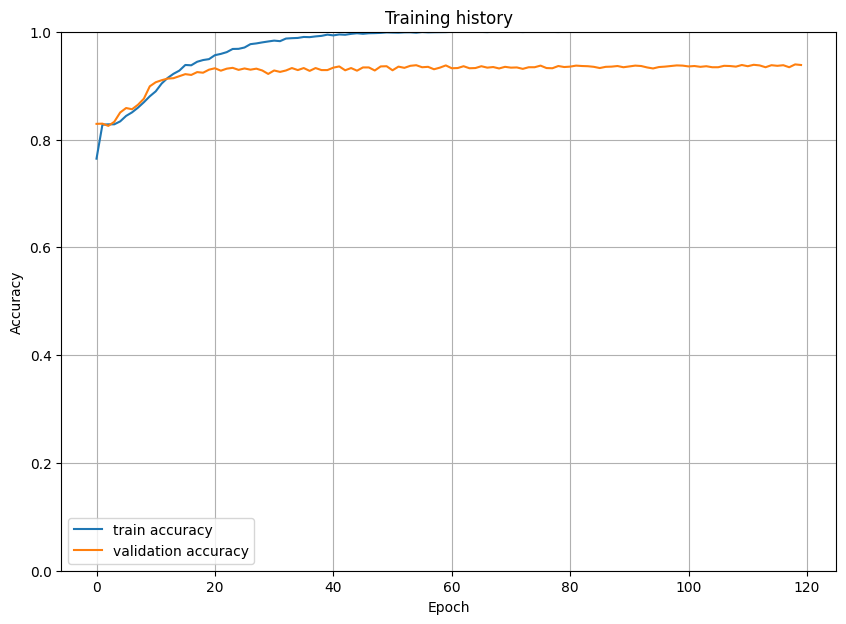

In [37]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
plt.grid()

**Evaluation of the model**

In [38]:
# Loading pretrained model (best model)
model = BERTClass()
model.load_state_dict(torch.load("/kaggle/working/BERT_MODEL.bin"))
model = model.to(device)
     

In [39]:
# Evaluate the model using the test data
test_acc, test_loss = eval_model(test_data_loader, model, optimizer)

In [40]:
test_acc

0.9230769230769231

In [41]:
def get_predictions(model, data_loader):
    """
    Outputs:
      predictions - 
    """
    model = model.eval()
    
    titles = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
        for data in data_loader:
            title = data["title"]
            ids = data["input_ids"].to(device, dtype = torch.long)
            mask = data["attention_mask"].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data["targets"].to(device, dtype = torch.float)

            outputs = model(ids, mask, token_type_ids)
            # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).detach().cpu()
            # thresholding at 0.5
            preds = outputs.round()
            targets = targets.detach().cpu()

            titles.extend(title)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            target_values.extend(targets)

    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)
    
    return titles, predictions, prediction_probs, target_values

In [42]:
titles, predictions, prediction_probs, target_values = get_predictions(model, test_data_loader)

In [43]:
# sanity check
predictions.numpy()

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 1., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 1., ..., 0., 0., 0.]], dtype=float32)

In [44]:
print(f"titles:{len(titles)} \npredictions:{predictions.shape} \nprediction_probs:{prediction_probs.shape} \ntarget_values:{target_values.shape}")

titles:143 
predictions:torch.Size([143, 8]) 
prediction_probs:torch.Size([143, 8]) 
target_values:torch.Size([143, 8])


In [45]:
print(classification_report(target_values, predictions, target_names=target_list))

              precision    recall  f1-score   support

     product       0.82      0.85      0.83        94
   packaging       0.86      0.88      0.87        42
      seller       0.81      0.88      0.85        25
     service       0.45      0.31      0.37        16
       shelf       1.00      0.90      0.95        10
    delivery       0.83      0.86      0.84        28
       rider       0.00      0.00      0.00         4
       price       0.82      0.96      0.88        24

   micro avg       0.82      0.82      0.82       243
   macro avg       0.70      0.70      0.70       243
weighted avg       0.80      0.82      0.81       243
 samples avg       0.81      0.82      0.80       243



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# > **Inference**

In [46]:
df_test

,reviewContent,product,packaging,seller,service,shelf,delivery,rider,price
103,এটি সত্যিই ভালো ভালোভাবে কাজ করছে শুভকামনা,1,0,0,0,0,0,0,0
854,মাত্র ৩২৩ টাকায় পেয়েছি হোম ডেলিভারি,0,0,0,0,0,1,0,1
195,খুব তাড়াতাড়ি পেয়েছি ও প্যাকেজিং ছিল খুব সুন...,1,1,0,0,0,0,1,0
1591,সুন্দর প্যাকেজিং এবং দ্রুত পেয়েছি,0,1,0,0,0,1,0,0
1020,"""ভালোভাবে প্যাক করা ভালো পণ্য সুপারিশ করছি""",1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
813,দুইবার ডেলিভারি চার্জ নিলো,0,0,0,0,0,1,0,0
1028,সব সময়ের মতোই ভালোকিন্তু এবার বেশি ভালো কারন ন...,1,0,0,0,0,0,0,1
51,প্রোডাক্টটি খুবই ভালো এর মূল্যের তুলনায় এটি আ...,1,0,0,0,0,0,0,1
901,ভাল কিন্তু দাম বেশি,0,0,0,0,0,0,0,1


In [47]:
# df_test.reviewContent[221]

In [48]:

# raw text
raw_text = """

আসা করি যে ভালো হবে কিন্তু অনেক ভালো ছিল চালে নিতে পারেন যে রকম কথা ছিল সেই রকম দিসে ধ্যনবাদ দারাজ এবং সেলার
"""

raw_text = clean_text(raw_text)
print(raw_text)

আসা করি যে ভালো হবে কিন্তু অনেক ভালো ছিল চালে নিতে পারেন যে রকম কথা ছিল সেই রকম দিসে ধ্যনবাদ দারাজ এবং সেলার


In [49]:
encoded_text = tokenizer.encode_plus(
    raw_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)
token_type_ids = encoded_text['token_type_ids'].to(device)
output = model(input_ids, attention_mask, token_type_ids)
 # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
output = torch.sigmoid(output).detach().cpu()
# thresholding at 0.5
output = output.flatten().round().numpy()
output

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



array([1., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

In [50]:
# Correctly identified the topic of the paper: High energy physics
print(f"Title: {raw_text}")
for idx, p in enumerate(output):
    if p==1:
        print(f"Label: {target_list[idx]}")

Title: আসা করি যে ভালো হবে কিন্তু অনেক ভালো ছিল চালে নিতে পারেন যে রকম কথা ছিল সেই রকম দিসে ধ্যনবাদ দারাজ এবং সেলার
Label: product
Label: seller


In [51]:
df_test.head()

,reviewContent,product,packaging,seller,service,shelf,delivery,rider,price
103,এটি সত্যিই ভালো ভালোভাবে কাজ করছে শুভকামনা,1,0,0,0,0,0,0,0
854,মাত্র ৩২৩ টাকায় পেয়েছি হোম ডেলিভারি,0,0,0,0,0,1,0,1
195,খুব তাড়াতাড়ি পেয়েছি ও প্যাকেজিং ছিল খুব সুন...,1,1,0,0,0,0,1,0
1591,সুন্দর প্যাকেজিং এবং দ্রুত পেয়েছি,0,1,0,0,0,1,0,0
1020,"""ভালোভাবে প্যাক করা ভালো পণ্য সুপারিশ করছি""",1,1,0,0,0,0,0,0


In [52]:
# আসা করি যে ভালো হবে কিন্তু অনেক ভালো ছিল চালে নিতে পারেন যে রকম কথা ছিল সেই রকম দিসে ধ্যনবাদ দারাজ এবং সেলার